In [1]:
import math
from pyspark.sql import SparkSession
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

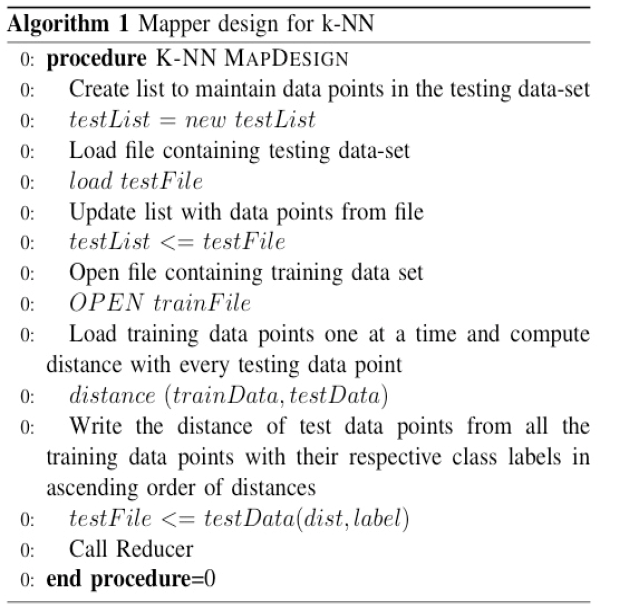 | 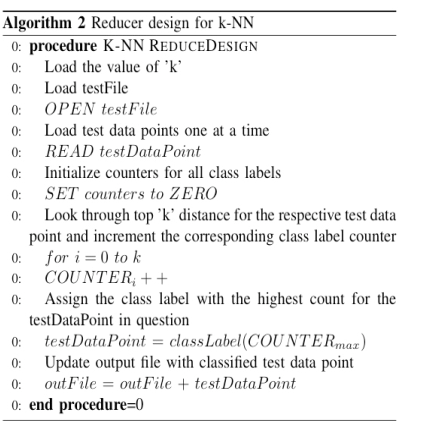 | 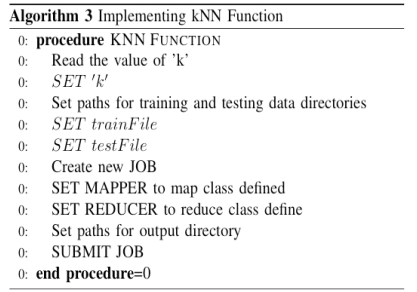

In [2]:
print("Starting KNN")
# Create a SparkSession
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("KNN")\
    .getOrCreate()

# Define Euclidean distance function
def euclidean_distance(row1, row2):
    dist = 0.0
    for i in range(len(row1) - 1):
        dist += (row1[i] - row2[i]) ** 2
    return math.sqrt(dist)

# Set the number of neighbors
k = 3

# Load the data
train_data = spark.read.csv('dataset/mini_sample.csv', header=True, inferSchema=True)
test_data = spark.read.csv('dataset/mini_sample_test.csv', header=True, inferSchema=True)

# Convert the data to RDD
train_rdd = train_data.rdd
test_rdd = test_data.rdd

# Broadcast train data
train_broadcast = spark.sparkContext.broadcast(train_rdd.collect())

def mapper(row):
    distances = []
    train_data = train_broadcast.value
    for train_row in train_data:
        dist = euclidean_distance(row, train_row)
        distances.append((dist, train_row[-1]))
    distances.sort(key=lambda x: x[0])
    return distances[:k]   # idx:(dist, class)

# Calculate the distance of each row in test data to all rows in train data
results = test_rdd.map(lambda row: mapper(row))

def reducer(row):
    classes = {}
    for i in range(k):
        if row[i][1] in classes:
            classes[row[i][1]] += 1
        else:
            classes[row[i][1]] = 1
    return max(classes, key=classes.get)    # idx:(class)


# Get the most common class for each row in test data
predictions = results.map(lambda row: reducer(row))

# Get the actual classes
actual = test_rdd.map(lambda row: row[-1]) 

# Get the most common class for each row in test data
predictions = results.map(lambda row: reducer(row))   

# Get the actual classes
actual = test_rdd.map(lambda row: row[-1])

print("gettig accuracy")

# Calculate the accuracy
correct = predictions.zip(actual).filter(lambda x: x[0] == x[1]).count()    # idx:(pred, actual)

accuracy = correct / float(test_rdd.count())

print("Accuracy: ", accuracy)

spark.stop()


Starting KNN
gettig accuracy
Accuracy:  0.66


## Comparing with sklearn KNN model

In [3]:
import pandas as pd

# Load the data
train = pd.read_csv('dataset/mini_sample.csv')
test = pd.read_csv('dataset/mini_sample_test.csv')

# Create the KNN model
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn.fit(train.iloc[:, :-1], train.iloc[:, -1])

# Make predictions
predictions = knn.predict(test.iloc[:, :-1])

# Calculate the accuracy

correct = sum(predictions == test.iloc[:, -1])

accuracy = correct / len(test)

print("Accuracy: ", accuracy)

Accuracy:  0.66
